EPI Notebook
============
**Note: this code will not run.
See /cubric/data/c24073803/pypulseq_repo/pypulseq/examples/scripts/write_epi.py for runnable script**

## Objectives
1. To decontruct and understand the lines of code within write_epi.py
2. To alter parameters and explore their resultant effect
3. To explore changing the shape of the RF pulse





**Rik Khot**\
**PhD Student**\
**Cardiff University School of Physics & Astronomy**\
**Supervisors: Kevin Murphy, Ian Driver, Emre Kopanoglu**

### EPI Theory

In [ ]:
#Import packages
import numpy as np
import pypulseq as pp


For information on the specific functions that are part of the pypulseq package [click this link](https://pypulseq.readthedocs.io/en/master/pypulseq.html).

### The Code
#### MAIN FUNCTION
The function main() contains all the code required to produce a .seq file.\
.seq files are what the MRI scanner reads to initiate a pulse sequence. \
The main() code also produces plots, which we will discuss further on.

In [ ]:
def main(plot: bool = False, write_seq: bool = False, seq_filename: str = 'epi_pypulseq.seq'):

Let us consider the variables:)
- plot
    - Variable of Boolean type (true/false)
- write_seq
    - Variable of Boolean type (true/false)
- seq_filename
    - Variable of string type 
    - Variable hardcoded as "epi_pypulseq.seq"

In [ ]:
# Define FOV and resoluti adc = pp.make_adc(
        num_samples=Nx,
        duration=readout_time,
        delay=gx.rise_time + flat_time / 2 - (readout_time - dwell_time) / 2,
    )
    slice_thickness = 3e-3  # Slice thickness
    n_slices = 3

N.B. We will assume that fov and slice thickness is quoted in **meters** 

The 1st section of the function hardcodes the values for:
1. Field of view (FOV)
    - *distance over which the MR image is acquired*
    - *FOV and pixel width determine how many digitised samples are required to construct an image with required resolution*
    - Spacing between k-space samples, $\Delta k = \frac{1}{FOV}$
2. Matrix size
    - relates to the number of pixels within an image
    - affects resolution and image quality
    would expect 128 x 128 or 256 x 256
3. Slice Thickness
    - Based on RF bandwidth
    - In general(NOT MR SPECIFIC), RF wavelength range: $~3mm - 300,000m$

4. No. of slices
    - $n_{maxslices} = \frac{TR}{TE}$

In [ ]:
# Set system limits
    system = pp.Opts(
        max_grad=32,
        grad_unit='mT/m',
        max_slew=130,
        slew_unit='T/m/s',
        rf_ringdown_time=30e-6,
        rf_dead_time=100e-6,
    )


pp.Opts() function passes the following variables (see documentation for more details).
- adc dead time (default = 0)
    - time taken to digitise continuous waveforms recieved

- gyromagnetic ratio (default value, proton)

- gradient raster time (default value)
    - *rasterization: converting continuous wave into discrete points*
    - *Grad raster time: time taken to "digitise" gradient waveforms*

- gradiant unit (default Hz/m)

- maximum gradient (default 0)

- maximum slew rate (default 0)
    - "quickest" gradient can ramp up to it's maximum amplitude

- RF dead time
    - when rf coil switches from transmit to recieve
    - cannot send or recieve data
    - *do we have only 1 rf coil?*

- RF raster time
    - time taken to digitise continuous RF pulses

- RF ringdown time
    - time taken for RF coil to chill out after emitting a pulse
    - to avoid interference/artefacts as much as possible

- rise time
    - time taken for gradient to ramp up to it's maximum amplitude

- slew unit (user specified, eg. T/m/s)


In [ ]:
 seq = pp.Sequence(system)  # Create a new sequence object

^^^^
Will be relevent later in sequence construction section

#### Creating Events

In [ ]:
# Create 90 degree slice selection pulse and gradient
    rf, gz, _ = pp.make_sinc_pulse(
        flip_angle=np.pi / 2,
        system=system,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        return_gz=True,
        delay=system.rf_dead_time,
    )

returns rf sinc pulse and slice select trapezoidal gradient (iff slice thickness defined)

Consider make_sinc_pulse() variables:

- flip angle in radians 
- apodization (default =0)
    - I think this reduces spectral contamination artefacts?
- centre_pos
    - position of peak (assumed midway?)
- delay (in seconds)
    - usually rf dead time
- duration (default = 0.004s)
- dwell? (default 0)
- freq_offset
- max_grad
    - maximum gradient for slice select waveform (trapezioid)
- max slew
    - of slice select gradient
- phase offset? Read on phase-offset multiplanar volume imaging [click this link](https://pubmed.ncbi.nlm.nih.gov/1790368/)
- return_delay (does a delay need to be returned)
- return_gz (does slice select gradient need to be returned)
- slice_thickness (default 0)
    -**pre-defined earlier in code during FOV and resolution**
- system
    - **defined earlier in code when system limits were set**
- time_bw_product (default 4)
- use (options include "excitation", "refocusing" or "inversion")





##### Defining gradients and ADC events

In [ ]:
 # Define other gradients and ADC events
    delta_k = 1 / fov
    k_width = Nx * delta_k
    dwell_time = 4e-6
    readout_time = Nx * dwell_time
    flat_time = np.ceil(readout_time * 1e5) * 1e-5  # round-up to the gradient raster
   

**REMEMBER $N_{x}$ and $N_{y}$ are the matrix sizes defined near line 1**
1. $\Delta k = \frac{1}{FOV}$
    - spacing between data points in k-space
2. $k_{width} = k_{FOV} = \frac{N_{x}}{FOV}$
3. Dwell time = ADC dead time after sampling
4. readout time = time taken to collect data points for single phase encoding line
5. flat time
    - np.ceil essentially rounds the value up to the nearest integer
    - don't really understand this equation
    - flat time is a specific property of fast-imaging sequences

    

In [ ]:
    gx = pp.make_trapezoid(
        channel='x',
        system=system,
        amplitude=k_width / readout_time,
        flat_time=flat_time,
    )
   


It seems that only "general" parameters are being defined within gx, as the negative and positive gradients need to be considered too.

Here we are defining the x-gradient properties.
make_trapeziod():

- Channel (is it in "x", "y" or "z"?)
- Amplitude (default = 0)
    - $g_{x} = \frac{k_{FOV}}{T_{read-out}}$
    - I don't understand this equation tbh
- Area (default 0)
- delay (default 0)
- duration of g_x is 0?? Why is this not defined in this simple EPI?
- flat_area (default 0)
- flat_time = defined earlier (default = -1)

+others






In [ ]:
adc = pp.make_adc(
        num_samples=Nx,
        duration=readout_time,
        delay=gx.rise_time + flat_time / 2 - (readout_time - dwell_time) / 2,
    )

**gx.rise_time??** unsure what's happening? bc you could calculate this based on the slew rate but I can't find an equation that's actually doing this?? Where is this defined like what

**Update** - this makes sense as system=system is defined within $g_{x}$, which is where the rise_time value is being recovered for gx.rise_time.

**Update 2.0** no this actually still doesn't make sense because system does not define rise_time, it can be calculated but where is this defined?!!!!!!!!!

In [ ]:

    # Pre-phasing gradients
    pre_time = 8e-4
    gx_pre = pp.make_trapezoid(channel='x', system=system, area=-gx.area / 2, duration=pre_time)
    gz_reph = pp.make_trapezoid(channel='z', system=system, area=-gz.area / 2, duration=pre_time)
    gy_pre = pp.make_trapezoid(channel='y', system=system, area=-Ny / 2 * delta_k, duration=pre_time)


pre-time is used to define the duration of all the prephasing gradients.

gz_reph is the rephasing gz gradient applied to refocus the spins.



In [ ]:
    # Phase blip in the shortest possible time
    dur = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / 10e-6) * 10e-6
    gy = pp.make_trapezoid(channel='y', system=system, area=delta_k, duration=dur)

So **What is a phase blip?**

To know more about this I will need to read more on EPI and fast scanning theory.



### SEQUENCE CONSTRUCTION

### Pulse Sequence Visualisations

### Function Call

### Output

From running the code we get the following outputs:

(a) epi_pypulseq.seq - file that is "fed" into the MR scanner, can access this /cubric/data/c24073803/pypulseq_repo/pypulseq/examples/scripts

(b) 6 graphs showing different componants of the EPI pulse sequence design



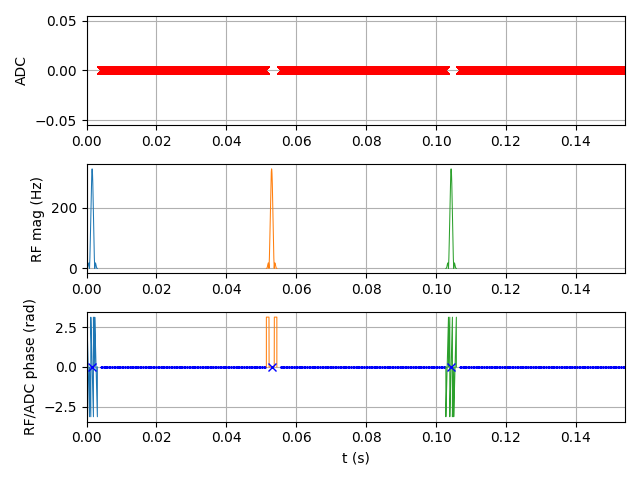

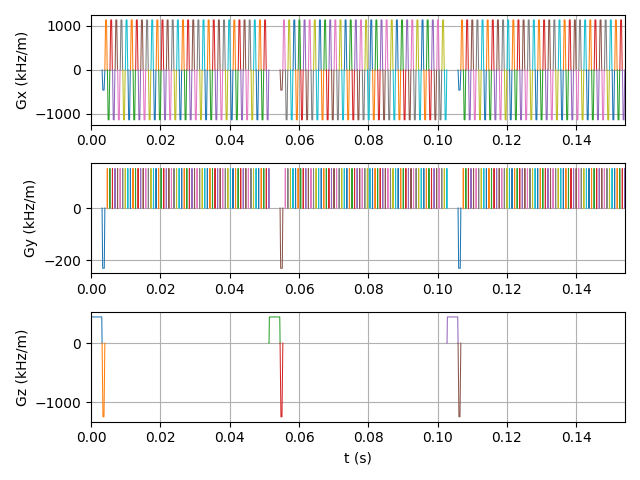



## Changing Parameters

**We will change various parameters in an attempt to understand how this affects the EPI pulse sequence generated.**

**Note: main issue with comparing differences is the scale of graphs change and there's no zoom in function - I will need to add this**

### Matrix ($N_{x}$, $N_{y}$)

Initial values:

$N_{x}$ = 64
$N_{y}$ = 64

#### 1. Nx,Ny = 128

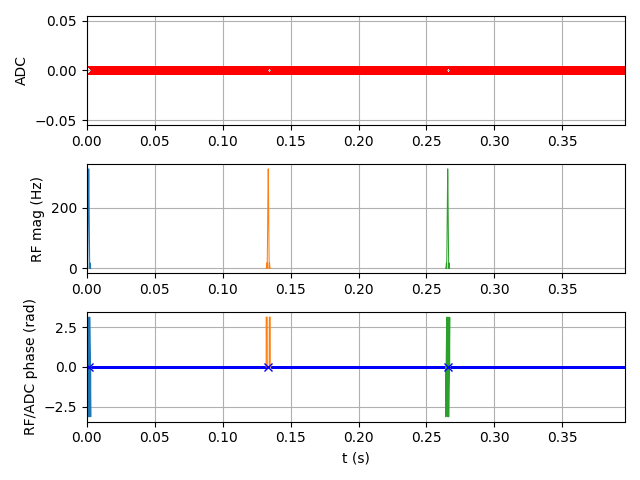  

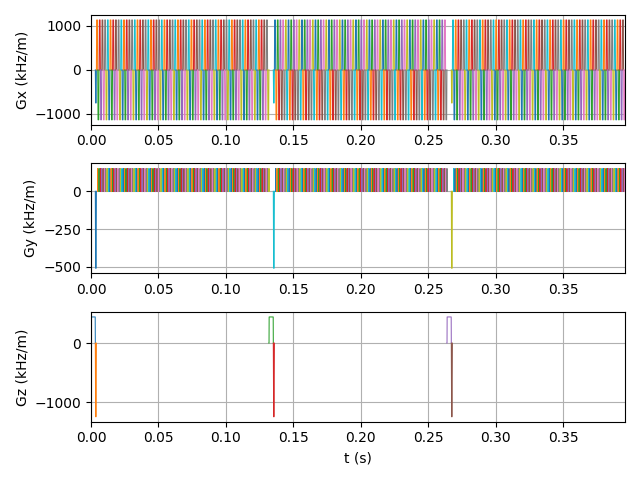

#### 2. Nx, Ny = 256

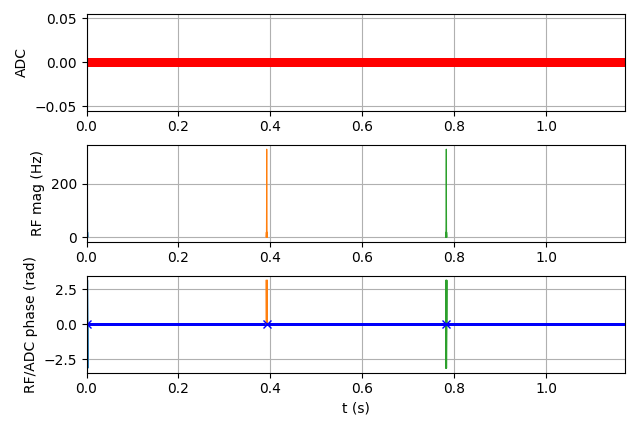   

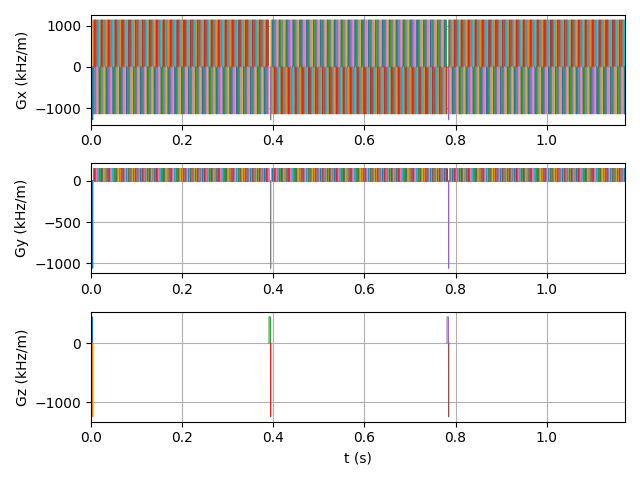

**Key Takeaways**
 As matrix size increases:

 - slower image acquisition time



### Field of View (FOV)

Initial value:

*fov = 220e-3 m (= 220mm)*

### 1. fov = 0.01mm

This didn't work as the Field of view is limited by the gradients. It seems the minimum fov is around 219mm-220mm which is not bad

### 2. fov = 

# References

mriquestions.com (fov, matrix size and resolution)
pypulseq documentation